In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import mpl_toolkits.mplot3d as plt3d
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import seaborn as sns
from scipy import stats
from tqdm import tqdm
import copy
from Farm_Evaluator_Vec import *

In [2]:
coords = pd.read_csv('submission11.csv').values

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(coords[:,0],coords[:,1],s=400,c='black',marker='2')

plt.xticks([])
plt.yticks([])
plt.show()

In [45]:
class LSHADE:
    
    def __init__(self,Np_ini,d,coords,turb,NFE_max,Np_min,penalty=False,gamma=0,is_fixed_coords=0,fixed_coords=None):
        self.Np_ini = Np_ini
        self.NFE_max = NFE_max
        self.Np_min = Np_min
        self.Np = Np_ini #population size
        self.d = d #total number of possible wind turbine locations in the discrete scenario(100)
        self.turb = turb #Number of turbines to be placed(50)
        self.Obj_vals = [] #Stores the objective values obtained in each generation
        self.F = [] #Stores scaling factors
        self.CR = [] #Stores crossover rates
        self.best_score = 0 #Maximum AEP found until any given instance(generation)
        self.X_all = [] #Stores all the decision vectors corresponding to all generations
        self.coords = coords #Coordinates of 100 discrete locations
        self.mu_f = 0.5 #Scaling factor mean used to generate scaling factor f
        self.mu_cr = 0.5 #Crossover Rate mean used to generate CRs
        self.mutate_vec = [] #Stores all the mutation vectors (v's)
        self.trial_vec = [] #Stores all the trial vectors(u's)
        self.NFE = 0
        self.is_fixed_coords = is_fixed_coords
        if is_fixed_coords:
            self.fixed_coords = fixed_coords
        self.penalty = penalty
        if penalty:
            self.gamma = gamma
            self.combs = list(combinations(list(range(self.turb)),2))
        self.best_score_hist = []
        self.best_coords_list = []
    
    def initialize(self):
        """
        Np = population size
        d = Dimension of decision vector; Number of discrete location
        turb = Number of turbines to be placed; 50 out of 100 dimensional vector will have 1's
        The function randomly initializes values between 0 and 1. This is the 0th generation population.
        """
        random_values = np.random.random((self.Np,self.d))
        columns = np.argsort(random_values,axis=-1)[:,-self.turb:].flatten()
        rows = np.repeat(list(range(self.Np)),repeats=self.turb)
        X = np.zeros((self.Np,self.d))
        X[rows,columns] = 1
        self.X_all.append(X)
        scores = []
        for x in X:
            scores.append(self.get_objective(x))
        self.Obj_vals.append(np.array(scores))
    
    def get_coords(self,x):
        """
        x is an array of length d with values between 0 and 1.
        The location of turbines is decided by sorting x and replacing the last 50 values with 1 and remaining as 0. 
        returns 50 coordinates out of 100 possible ones based on x.
        """
        locs = np.argsort(x)[-self.turb:]
        co = self.coords[locs.tolist()]
        if self.is_fixed_coords:
            co = np.vstack((co,self.fixed_coords))
        return co
    
    def get_objective(self,x):
        """
        x is an array of length d with values between 0 and 1.
        returns objective value corresponding to x
        """
        co = self.get_coords(x)
        P = get_objective_value(co,get_each_turb_aep=0)
        return P - self.get_penalty(co)
    
    def get_penalty(self,co):
        pen = 0
        if self.penalty:
            for c in self.combs:
                turb1 = co[c[0]]
                turb2 = co[c[1]]
                prox = np.linalg.norm(turb1 - turb2) - 400
                if prox<0:
                    pen -= prox
            return self.gamma*pen
        else:
            return 0
    
    def update_best_score(self,t):
        """
        Evaluates all the decision vectors corresponding to a given generation and stores in Obj_vals.
        t is used to identify t-th generation.
        Also finds the best objective function value till the current generation.
        """
        score = max(self.Obj_vals[t])
        max_ind = np.argmax(self.Obj_vals[t])
        if score>self.best_score:
            self.best_score = score
            self.best_x = self.X_all[t][max_ind]
            self.best_coords = self.get_coords(self.X_all[t][max_ind])
            #self.best_coords_list.append(self.best_coords)
            
    
    def get_p_best(self,t,p=0.05):
        """
        p is the percentile of the best population individuals.
        x_pbest is chosen randomly from Np*p best individuals.
        returns x_pbest
        """
        P = int(self.Np*p)
        inds = np.argsort(self.Obj_vals[t])[-P:]
        p_best = np.random.choice(inds,1)[0]
        return self.X_all[t][p_best] 
    
    def get_f(self):
        """
        Scaling factors for a generation are drawn from cauchy distribution with mean 0.5 and variance 0.1
        """
        F = stats.cauchy.rvs(loc=self.mu_f,scale=np.sqrt(0.1),size=self.Np)
        return F
    
    def get_cr(self):
        """
        Crossover rates are drawn from normal distribution with mean 0.5 and variance 0.1
        """
        CR = np.random.normal(loc=self.mu_cr,scale=np.sqrt(0.1),size=self.Np)
        return CR
    
    def parameter_adaptation(self,t,p=0.05):
        if t>=1: 
            P = int(self.Np*p)    
            inds = np.argsort(self.Obj_vals[t])[-P:].tolist()
            self.mu_f = (self.mu_f + np.mean(self.F[t-1][inds]))/2
            self.mu_cr = (self.mu_cr + np.mean(self.CR[t-1][inds]))/2
    
    def mutation(self,t):
        """
        generates mutant vector v using scaling factor, x_pbest and current generation samples (X)
        """
        x_pbest = np.array(self.get_p_best(t))
        X = self.X_all[t]
        F = self.get_f()
        r1 = np.random.choice(list(range(self.Np)),size=self.Np).tolist()
        r2 = np.random.choice(list(range(self.Np)),size=self.Np).tolist()
        X_r1, X_r2 = X[r1], X[r2]
        V = np.zeros((self.Np,self.d))
        for i in range(self.Np):
            V[i] = X[i] + F[i] * (x_pbest - X[i]) + F[i] * (X_r1[i]-X_r2[i])
        V[V>1] = (X[V>1]+1)/2 #If v goes above 1 or below 0 bring it back within the range.
        V[V<0] = X[V<0]/2
        self.mutate_vec.append(V)
        self.F.append(F.flatten())
        
    def crossover(self,t):
        """
        generates trial vectors u using cross over rates and mutant vectors.
        """
        U = np.zeros((self.Np,self.d))
        V = self.mutate_vec[t]
        X = self.X_all[t]
        K = np.random.choice(list(range(self.Np)),size=1)[0]
        CR = self.get_cr()
        self.CR.append(CR)
        random_values = np.random.random((self.Np,self.d))
        for i in range(self.Np):
            for j in range(self.d):
                if j==K or random_values[i,j] <= CR[i]:
                    U[i,j] = V[i,j]
                else:
                    U[i,j] = X[i,j]
        self.trial_vec.append(U)
    
    def drop_rows(self,X,final_length,t):
        X_1 = X[np.argsort(self.Obj_vals[t+1])[-final_length:].tolist()]
        self.Obj_vals[t+1] = self.Obj_vals[t+1][np.argsort(self.Obj_vals[t+1])[-final_length:].tolist()]
        return X_1
    
    def selection(self,t):
        """
        The next generation (t+1) vectors are selected based on objective function values for x and u.
        """
        X_1 = np.zeros((self.Np,self.d))
        X = self.X_all[t]
        U = self.trial_vec[t]
        scores = np.zeros(self.Np)
        for i in range(self.Np):
            f_x = self.Obj_vals[t][i]
            f_u = self.get_objective(U[i])
            if f_x>=f_u:
                X_1[i] = X[i]
                scores[i] = f_x
            else:
                X_1[i] = U[i]
                scores[i] = f_u
        self.Obj_vals.append(scores)
        columns = np.argsort(X_1,axis=-1)[:,-self.turb:].flatten()
        rows = np.repeat(list(range(self.Np)),repeats=self.turb)
        X_1[rows,columns] = 1
        self.NFE += self.Np
        #self.population_size_reduction()
        #X_1 = self.drop_rows(X_1,self.Np,t)
        self.X_all.append(X_1)
        
        
    def population_size_reduction(self):
        self.Np = (self.Np_min-self.Np_ini)/self.NFE_max * self.NFE + self.Np_ini
        self.Np = int(self.Np)
    
    def run(self,run_from_middle=0,starting_x=None):
        if run_from_middle:
            self.X_all.append(starting_x)
            scores = []
            for x in X_ini:
                scores.append(self.get_objective(x))
            self.Obj_vals.append(np.array(scores))
        else:
            self.initialize()
        t = 0
        while self.NFE <= self.NFE_max:
            self.update_best_score(t)
            print('{:.4f}'.format(self.best_score))
            self.mutation(t)
            self.crossover(t)
            self.selection(t)
            self.best_coords_list.append(self.best_coords)
            self.best_score_hist.append(self.best_score)
            t += 1
            #self.parameter_adaptation(t)

In [4]:
power_curve  =  loadPowerCurve('Shell_Hackathon Dataset/power_curve.csv')
n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = preProcessing(power_curve)
wind_inst_freq =  binWindResourceData('Shell_Hackathon Dataset/Wind Data/combined_data.csv')
def get_objective_value(coords,constraint_check=False,year=None,verbose=0,n_wind_instances=n_wind_instances, cos_dir=cos_dir, sin_dir=sin_dir, wind_sped_stacked=wind_sped_stacked, C_t=C_t,wind=1,wind_inst_freq=wind_inst_freq,get_each_turb_aep=1):
    turb_specs = {'Name': 'Anon Name','Vendor': 'Anon Vendor','Type': 'Anon Type','Dia (m)': 100,
                  'Rotor Area (m2)': 7853,'Hub Height (m)': 100,'Cut-in Wind Speed (m/s)': 3.5,'Cut-out Wind Speed (m/s)': 25,
                  'Rated Wind Speed (m/s)': 15,'Rated Power (MW)': 3}
    turb_diam  =  turb_specs['Dia (m)']
    turb_rad   =  turb_diam/2 
    
    if wind==0:
        if year == None:
            mean_AEP = 0
            for y in [2007,2008,2009,2013,2014,2015,2017]:
                wind_inst_freq =  binWindResourceData('Shell_Hackathon Dataset/Wind Data/wind_data_'+str(y)+'.csv')
                mean_AEP += getAEP(turb_rad, coords, power_curve, wind_inst_freq, 
                          n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t) 
            mean_AEP /= 7

            if verbose:
                print('Average power produced by the wind farm over 7 years is: ', "%.12f"%(mean_AEP), 'GWh')

            return mean_AEP
        else:
            wind_inst_freq =  binWindResourceData('Shell_Hackathon Dataset/Wind Data/wind_data_'+str(year)+'.csv')
            AEP = getAEP(turb_rad, coords, power_curve, wind_inst_freq, 
                          n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t)

            if verbose:
                print('Total power produced by the wind farm is: ', "%.12f"%(AEP), 'GWh')

            return AEP
        
    else:
        #penalty = checkConstraints(coords,turb_diam)
        
        AEP = getAEP(turb_rad, coords, power_curve, wind_inst_freq, 
              n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t,get_each_turb_aep)
        
        return AEP
    
def plot_turbines(coords):
    plt.figure(figsize=(10,10))
    plt.scatter(coords[:,0],coords[:,1],color='b',s=200)
    plt.show()

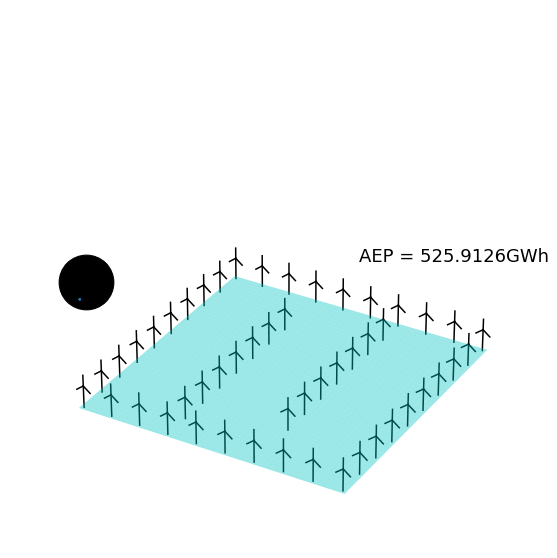

In [147]:
coords = ls1.best_coords
plot_name = 'x'
h = 10
coords_3d = []
for x,y in zip(coords[:,0],coords[:,1]):
    for z in [0,h]:
        coords_3d.append([x,y,z])
coords_3d = np.array(coords_3d)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d', aspect='auto')
ax.scatter3D(coords_3d[:,0],coords_3d[:,0],coords_3d[:,0],s=1,marker='o')
ax.set_zlim([0,h])
X,Y = np.meshgrid(np.linspace(0,4000,100),np.linspace(0,4000,100))
Z = np.zeros((100,100))
'''X,Y = X.flatten(),Y.flatten()'''
ax.plot_surface(X,Y,Z,color='aqua',alpha=0.4)
#ax.scatter3D(X,Y,Z,s=1,marker='o',c='deepskyblue')
for x,y in coords:
    xs = x,x
    ys = y,y
    zs = 0,h
    line = plt3d.art3d.Line3D(xs, ys, zs,color='black')
    ax.add_line(line)
aep=np.round(get_objective_value(coords,get_each_turb_aep=0),4)
ax.text(2700, 2700, 50, 'AEP = '+str(aep)+'GWh', color='black',fontsize=18)
x_scale=1
y_scale=1
z_scale=0.1

for x,y in coords:
    xs = x,x-120*np.cos(np.pi/6)
    ys = y,y
    zs = 10,10-5*0.5
    line = plt3d.art3d.Line3D(xs, ys, zs,color='black')
    ax.add_line(line)
    xs = x,x
    ys = y,y
    zs = 10,15
    line = plt3d.art3d.Line3D(xs, ys, zs,color='black')
    ax.add_line(line)
    xs = x,x+120*np.cos(np.pi/6)
    ys = y,y
    zs = 10,10-5*0.5
    line = plt3d.art3d.Line3D(xs, ys, zs,color='black')
    ax.add_line(line)

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
    return np.dot(Axes3D.get_proj(ax), scale)

ax.get_proj=short_proj
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.axis('off')
plt.savefig('Animation Plots/'+plot_name,dpi=200)
plt.show()

In [122]:
def save_animation_plot(coords,plot_name):
    h = 10
    coords_3d = []
    for x,y in zip(coords[:,0],coords[:,1]):
        for z in [0,h]:
            coords_3d.append([x,y,z])
    coords_3d = np.array(coords_3d)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d', aspect='auto')
    ax.scatter3D(coords_3d[:,0],coords_3d[:,0],coords_3d[:,0],s=1,marker='o')
    ax.set_zlim([0,h])
    for x,y in coords:
        xs = x,x
        ys = y,y
        zs = 0,h
        line = plt3d.art3d.Line3D(xs, ys, zs,color='black')
        ax.add_line(line)
    X,Y = np.meshgrid(np.linspace(0,4000,100),np.linspace(0,4000,100))
    Z = np.zeros((100,100))
    ax.plot_surface(X,Y,Z,color='aqua',alpha=0.4)
    x_scale=1
    y_scale=1
    z_scale=0.1

    for x,y in coords:
        xs = x,x-120*np.cos(np.pi/6)
        ys = y,y
        zs = 10,10-5*0.5
        line = plt3d.art3d.Line3D(xs, ys, zs,color='black')
        ax.add_line(line)
        xs = x,x
        ys = y,y
        zs = 10,15
        line = plt3d.art3d.Line3D(xs, ys, zs,color='black')
        ax.add_line(line)
        xs = x,x+120*np.cos(np.pi/6)
        ys = y,y
        zs = 10,10-5*0.5
        line = plt3d.art3d.Line3D(xs, ys, zs,color='black')
        ax.add_line(line)
        
    aep=np.round(get_objective_value(coords,get_each_turb_aep=0),4)
    ax.text(2700, 2700, 50, 'AEP = '+str(aep)+'GWh', color='black',fontsize=20)
    
    scale=np.diag([x_scale, y_scale, z_scale, 1.0])
    scale=scale*(1.0/scale.max())
    scale[3,3]=1.0

    def short_proj():
        return np.dot(Axes3D.get_proj(ax), scale)

    ax.get_proj=short_proj
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    plt.axis('off')
    plt.savefig('Animation Plots/'+plot_name,dpi=200)
    plt.close(fig)

In [53]:
X=np.linspace(50,3950,10)
grid_coords = []
for x in X:
    for y in X:
        grid_coords.append([x,y])
grid_coords = np.array(grid_coords)
d = len(grid_coords)
turb = 50
n_max = 30000
Np = 300
np_min = 4
ls1 = LSHADE(Np,d,grid_coords,turb,n_max,np_min,penalty=False,gamma=0)
ls1.run(run_from_middle=1,)

516.4386
516.4386
516.4386
516.4386
516.4386
516.4386
517.7100
517.7100
517.7100
517.7100
517.7100
518.0844
518.2925
518.8102
519.1554
519.7210
519.7210
519.8260
519.8681
520.0236
520.6462
520.6462
520.6462
521.5995
521.5995
521.5995
521.5995
521.5995
521.5995
521.5995
521.5995
522.3362
522.3362
522.3362
522.3362
522.3810
522.4302
522.4302
522.6161
522.9537
522.9537
523.0315
523.1819
523.1819
523.1819
523.3886
523.3886
523.3886
523.4528
523.4528
523.6940
523.6940
523.6940
523.6941
523.8092
523.8253
523.8253
523.8253
524.0718
524.0718
524.0718
524.2626
524.2626
524.3597
524.3597
524.4045
524.4045
524.4045
524.4045
524.4045
524.4045
524.4045
524.5096
524.5096
524.6349
524.9655
524.9655
524.9655
524.9912
524.9912
524.9912
525.0247
525.3762
525.3762
525.3762
525.3762
525.3762
525.3762
525.3762
525.3762
525.3762
525.3762
525.3762
525.3762
525.4375
525.4638
525.4638
525.9126
525.9126
525.9126
525.9126


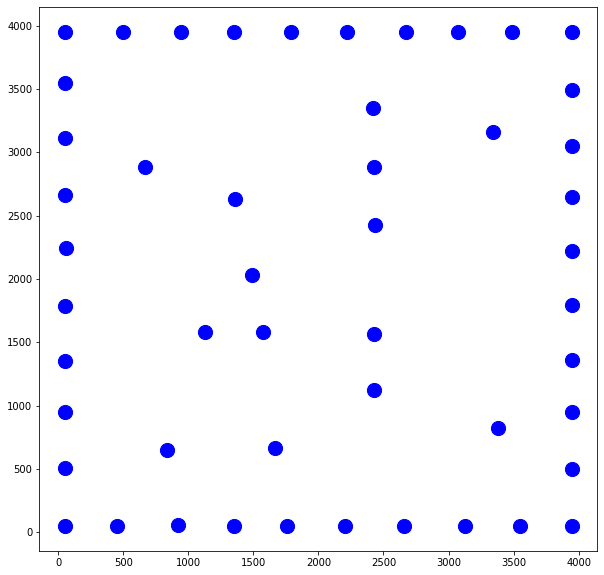

In [91]:
plot_turbines(pd.read_csv('submission19.csv').values)

In [126]:
i = 1
for coords in tqdm(ls1.best_coords_list):
    save_animation_plot(coords,plot_name='3d_plot_'+str(i)+'.jpg')
    i+=1
coords = pd.read_csv('submission11.csv').values
i=102
save_animation_plot(coords,plot_name='3d_plot_'+str(i)+'.jpg')
i=103
coords = pd.read_csv('submission54.csv').values
save_animation_plot(coords,plot_name='3d_plot_'+str(i)+'.jpg')


for i in tqdm(range(1,104)):
    image_path = image_folder+'3d_plot_'+str(i)+'.jpg'
    crop_image(image_path)

import cv2
import os
image_folder = 'Animation Plots/'
video_name = 'turbine_animation.mp4'

frame = cv2.imread('Animation Plots/3d_plot_1.jpg')
height, width, layers = frame.shape
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc('A','V','C','1'), 8, (width,height))
images = []

for i in tqdm(range(1,104)):
    img_name = '3d_plot_'+str(i)+'.jpg'
    video.write(cv2.imread(image_folder+img_name))
    
cv2.destroyAllWindows()
video.release()

100%|██████████| 103/103 [00:01<00:00, 78.19it/s]


In [132]:
img = Image.open(image_path)


In [125]:
from PIL import Image
def crop_image(image_path):
    img = Image.open(image_path)
    width, height = img.size 

    left = 400
    top = 900
    right = 1850
    bottom = 1600
    im = img.crop((left, top, right, bottom)) 
    im.save(image_path)

In [34]:
def compress_img(image_path):
    picture = Image.open(image_path) 
    picture.save(image_path,  
                 "JPEG",  
                 optimize = True,  
                 quality = 10)

In [148]:
coords = ls1.best_coords

In [157]:
X,Y = np.meshgrid(np.linspace(50,3950,100),np.linspace(50,3950,100))
Z = np.zeros((100,100))
for i in tqdm(range(100)):
    for j in range(100):
        temp_coords = coords.copy()
        temp_coords[0] = [X[i,j],Y[i,j]]
        Z[i,j] = -get_objective_value(temp_coords,get_each_turb_aep=0)

100%|██████████| 100/100 [09:38<00:00,  5.78s/it]


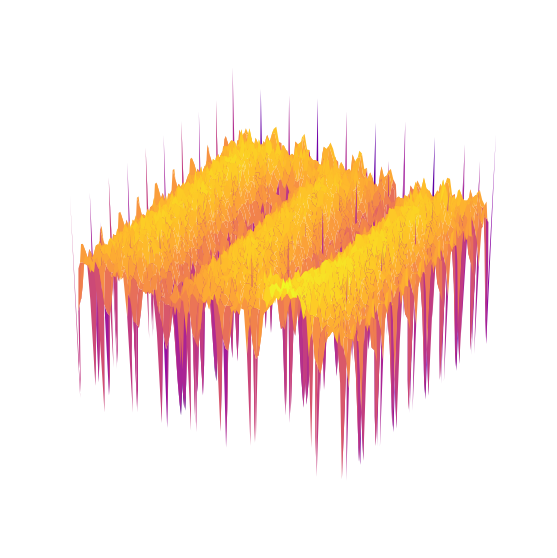

In [169]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d', aspect='auto')
ax.plot_surface(X,Y,-Z,cmap='plasma')
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.axis('off')
plt.savefig('Local minimas.jpg',dpi=200)
plt.show()